In [ ]:
#@title Install necessary libraries
!pip install transformers[torch]  # Install transformers with PyTorch support
!pip install biopython  # Install Biopython for sequence handling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.2 MB/s eta 0:00:00


In [ ]:
#@title Import necessary libraries
import urllib
from transformers import EsmForSequenceClassification, EsmTokenizer, pipeline
import numpy as np
import pandas as pd
from Bio import SeqIO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [ ]:
#@title Load the dataset
def load_dataset():
  # Specify the column names
  col_pos_train = ['ID', 'Species', 'Kingdom', 'Length', 'Cleavage', 'Set']
  col_neg_train = ['ID', 'Species', 'Kingdom', 'Length', 'Transmembrane', 'Set']
  col_pos_bench = ['ID', 'Species', 'Kingdom', 'Length', 'Cleavage']
  col_neg_bench = ['ID', 'Species', 'Kingdom', 'Length', 'Transmembrane']

  # Load the TSV file into a DataFrame
  pos_train = pd.read_csv('pos-train.tsv', sep='\t', header=None, names=col_pos_train)
  neg_train = pd.read_csv('neg-train.tsv', sep='\t', header=None, names=col_neg_train)
  pos_bench = pd.read_csv('pos-bench.tsv', sep='\t', header=None, names=col_pos_bench)
  neg_bench = pd.read_csv('neg-bench.tsv', sep='\t', header=None, names=col_neg_bench)

  # Create a customize files for train and val (for both positives and negatives): 1,2,3 train, 4,5 for val
  with open('positive.fasta', 'r') as read:
    with open('train.sp.fasta', 'w') as train:
      with open('val.sp.fasta', 'w') as val:
        for line in read:
          if '>' in line:
            line = line[1:].rstrip()
            query = pos_train.query("ID == @line")
            if not query.empty:
              line = read.readline()
              # The final line will contain: id, class, the first 1022 residues (because the embedding can support at most 1022 characters)
              if (query['Set'].iloc[0] == 5) or (query['Set'].iloc[0] == 4):
                print(f">{query['ID'].iloc[0]}:1\n{line.rstrip()[:1022]}", file=val)
              else:
                print(f">{query['ID'].iloc[0]}:1\n{line.rstrip()[:1022]}", file=train)
      val.close
    train.close
  read.close

  with open('negative.fasta', 'r') as read:
    with open('train.sp.fasta', 'a') as train:
      with open('val.sp.fasta', 'a') as val:
        for line in read:
          if '>' in line:
            line = line[1:].rstrip()
            query = neg_train.query("ID == @line")
            if not query.empty:
              line = read.readline()
              # The final line will contain: id, class, the first 1022 residues (because the embedding can support at most 1022 characters)
              if (query['Set'].iloc[0] == 5) or (query['Set'].iloc[0] == 4):
                print(f">{query['ID'].iloc[0]}:0\n{line.rstrip()[:1022]}", file=val)
              else:
                print(f">{query['ID'].iloc[0]}:0\n{line.rstrip()[:1022]}", file=train)
      val.close
    train.close
  read.close

  # Create a customize file for the test with both positive and negatives
  with open('positive.fasta', 'r') as read:
    with open('test.sp.fasta', 'w') as write:
      for line in read:
        if '>' in line:
          line = line[1:].rstrip()
          query = pos_bench.query("ID == @line")
          if not query.empty:
            line = read.readline()
            # The final line will contain: id, class, the first 1022 residues (because the embedding can support at most 1022 characters)
            print(f">{query['ID'].iloc[0]}:1\n{line.rstrip()[:1022]}", file=write)
    write.close
  read.close

  with open('negative.fasta', 'r') as read:
    with open('test.sp.fasta', 'a') as write:
      for line in read:
        if '>' in line:
          line = line[1:].rstrip()
          query = neg_bench.query("ID == @line")
          if not query.empty:
            line = read.readline()
            # The final line will contain: id, class, the first 1022 residues (because the embedding can support at most 1022 characters)
            print(f">{query['ID'].iloc[0]}:0\n{line.rstrip()[:1022]}", file=write)
    write.close
  read.close

In [ ]:
device = 'cuda'

In [ ]:
#@title Import the model
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)
model = EsmForSequenceClassification.from_pretrained(model_name)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [ ]:
#@title Compute the embedding
# Given a sequence, encode the sequence and extract the embedding
def compute_embeddings(sequence):
  inputs = tokenizer(sequence, return_tensors="pt") # Prepare the sequence, return the sequence in a pytorch tensor
  inputs.to(device) # Move the tensor in the device
  outputs = model(**inputs, output_hidden_states=True)
  hidden_states = outputs.hidden_states  # Get all hidden states: huge tensor where there are the output of all the 33 layers.
  embeddings = hidden_states[-1][0][1:91,:]  # Extract embeddings from the last layer
  return embeddings

In [ ]:
#@title Extraction of the input
def extract_XY(file):
    M = []
    Y = []
    i = 0

    for record in SeqIO.parse(file, "fasta"):
        i += 1
        sequence = str(record.seq)
        y = record.id.split(":")[1]
        Y.append(y)  # Store the label

        # Process embeddings in smaller steps
        with torch.no_grad():  # No need for gradient tracking
            inputs = tokenizer(sequence, return_tensors="pt")  # Prepare the sequence tensor
            inputs.to(device)  # Move to GPU

            # Run the model and get hidden states
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            embeddings = hidden_states[-1][0][1:91, :]  # Extract last layer embeddings

            # Detach, transfer to CPU, and convert to numpy for averaging
            mean_embedding = np.mean(embeddings.detach().cpu().numpy(), axis=0)
            M.append(mean_embedding)
            if i%100==0:
              print(i)

            # Clear cache to avoid memory buildup
            del inputs, outputs, hidden_states, embeddings  # Free up memory
            #torch.cuda.empty_cache()  # Clear cached memory

    return np.array(M), np.array(Y)


Extract input and actual truth

In [ ]:
# Test Set
test_M, test_Y = extract_XY("test.sp.fasta")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [ ]:
# Training set
train_M, train_Y = extract_XY("train.sp.fasta")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100


In [ ]:
# Validation set
val_M, val_Y = extract_XY("val.sp.fasta")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [ ]:
# Checks
print(f'Train:\nM={train_M.shape}, Y={train_Y.shape}')
print(f'Validation:\nM={val_M.shape}, Y={val_Y.shape}')
print(f'Test:\nM={test_M.shape}, Y={test_Y.shape}')

Train:
M=(6145, 1280), Y=(6145,)
Validation:
M=(1754, 1280), Y=(1754,)
Test:
M=(1975, 1280), Y=(1975,)


In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the model
class SPMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_p=0.5):
        super(SPMLP, self).__init__()
        # 3 layers + output layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU() #relu as activation function
        self.dropout1 = nn.Dropout(p=dropout_p) #dropout
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_p)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.sigmoid = nn.Sigmoid()
        #all the output are normalized between 0 and 1, this has a meaning of probability (sum of all the outputs gives 1): each output neuron gives the probability of the input to be in that class.

    def forward(self, x): #fully connected. apply all the layers until the output layer.
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

# Define a custom dataset
# class to handle all the dataset as minibatch (minibatch training cycle)
class SPDataset(Dataset):
    def __init__(self, X, y): #extend the class to keep the data and pass them to the loader that manage the minibatched
        self.X = torch.tensor(X, dtype=torch.float32)

        # Convert string labels to numerical labels to have categorical labels
        unique_labels = np.unique(y)
        label_mapping = {label: i for i, label in enumerate(unique_labels)}
        labels = np.array([label_mapping[label] for label in y])
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def test(model, test_loader, scorer = matthews_corrcoef):
  """Test the model on the test set and calculate the performance metrics"""
  model.eval()
  all_preds = []
  all_labels = []

  # Disable gradient computation for inference to save memory and computation
  with torch.no_grad():
      for batch_X, batch_y in test_loader:
          batch_X, batch_y = batch_X.to(device), batch_y.to(device) # Move all to the right device
          outputs = model(batch_X) # Do the prediction
          preds = torch.argmax(outputs, dim=1) # Convert into labels the raw model outputs
          # Store predictions and actual labels
          all_preds.extend(preds.cpu().numpy().flatten())
          all_labels.extend(batch_y.cpu().numpy().flatten())

  # Compute the scoring metrics
  score = scorer(all_labels, all_preds)
  accuracy = accuracy_score(all_labels, all_preds)
  mcc = matthews_corrcoef(all_labels, all_preds)
  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  cm = confusion_matrix(all_labels, all_preds)

  # Save the scoring metrics in an external file
  print('Test score: {:.4f}'.format(score))
  with open('DL_bench_res.txt', 'w') as write:
    print(f'Confusion Matrix:\n{cm}', file=write)
    print('Accuracy: '+str(accuracy)+'\nPrecision: '+str(precision)+'\nRecall: '+str(recall)+'\nF1 Score: '+str(f1)+'\nMCC: '+str(mcc)+'\n', file=write)
  write.close

# Check the availability of the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [ ]:
import matplotlib.pyplot as plt

# Training and validation procedure
def train_val_print(model, train_loader, val_loader, optimizer, criterion, epochs, patience, scorer = matthews_corrcoef, init_best_score = -1):
  train_losses = []
  val_losses = []
  best_val_score = init_best_score
  epochs_without_improvement = 0
  best_model_state_dict = None

  for epoch in range(epochs):
      # Training
      model.train()
      running_train_loss = 0.0 #training loss for the epoch

      for batch_X, batch_y in train_loader:
          batch_X, batch_y = batch_X.to(device), batch_y.to(device) #transfer the batch to the correct device
          optimizer.zero_grad() #set up the gradient

          outputs = model(batch_X) #model prediction
          loss = criterion(outputs, batch_y) #compute the loss between predictions and actual labels
          loss.backward() #compute the gradient
          optimizer.step() #update the parameters

          running_train_loss += loss.item() #add the training loss

      # Compute average training loss for the epoch
      avg_train_loss = running_train_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      # Validation
      model.eval()
      val_preds = []
      val_labels = []
      running_val_loss = 0.0

      # Disable gradient computation for efficiency
      with torch.no_grad():
          for batch_X, batch_y in val_loader:
              batch_X, batch_y = batch_X.to(device), batch_y.to(device) #move all to the appropriate device
              outputs = model(batch_X) #prediction
              # Compute the validation loss
              loss = criterion(outputs, batch_y)
              running_val_loss += loss.item()
              # Convert raw outputs in labels
              preds = torch.argmax(outputs, dim=1)
              # Store predictions and actial labels
              val_preds.extend(preds.cpu().numpy().flatten())
              val_labels.extend(batch_y.cpu().numpy().flatten())

      #Compute the validation metric
      val_score = scorer(val_labels, val_preds) #mcc -> stop the training when I see that the mcc is not improving for a certain number of epoches.
      # Compute average validation loss for the epoch
      avg_val_loss = running_val_loss / len(val_loader)
      val_losses.append(avg_val_loss)

      # Check the improvement of the scores
      if val_score > best_val_score:
          best_val_score = val_score
          epochs_without_improvement = 0
          best_model_state_dict = model.state_dict()
          print('Validation score improved to {:.4f}'.format(best_val_score))
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= patience:
              print('Early stopping at epoch {}'.format(epoch+1))
              break

      print('Epoch [{}/{}], Loss: {:.4f}, Val score: {:.4f}'.format(epoch+1, epochs, loss.item(), val_score))
  # Return the best model state dictionary and recorded loss values
  return best_model_state_dict, train_losses, val_losses

# Plotting the training and validation loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

Validation score improved to 0.0000
Epoch [1/100], Loss: 0.3133, Val score: 0.0000
Validation score improved to 0.9437
Epoch [2/100], Loss: 0.3133, Val score: 0.9437
Epoch [3/100], Loss: 0.3133, Val score: 0.8548
Validation score improved to 0.9675
Epoch [4/100], Loss: 0.3133, Val score: 0.9675
Validation score improved to 0.9766
Epoch [5/100], Loss: 0.3133, Val score: 0.9766
Epoch [6/100], Loss: 0.3133, Val score: 0.9752
Epoch [7/100], Loss: 0.3133, Val score: 0.9748
Epoch [8/100], Loss: 0.3133, Val score: 0.9729
Epoch [9/100], Loss: 0.3133, Val score: 0.9675
Epoch [10/100], Loss: 0.3133, Val score: 0.9750
Epoch [11/100], Loss: 0.3133, Val score: 0.9713
Epoch [12/100], Loss: 0.3133, Val score: 0.9747
Epoch [13/100], Loss: 0.3133, Val score: 0.9663
Epoch [14/100], Loss: 0.3133, Val score: 0.9732
Epoch [15/100], Loss: 0.3133, Val score: 0.9713
Validation score improved to 0.9784
Epoch [16/100], Loss: 0.3133, Val score: 0.9784
Validation score improved to 0.9820
Epoch [17/100], Loss: 0.3

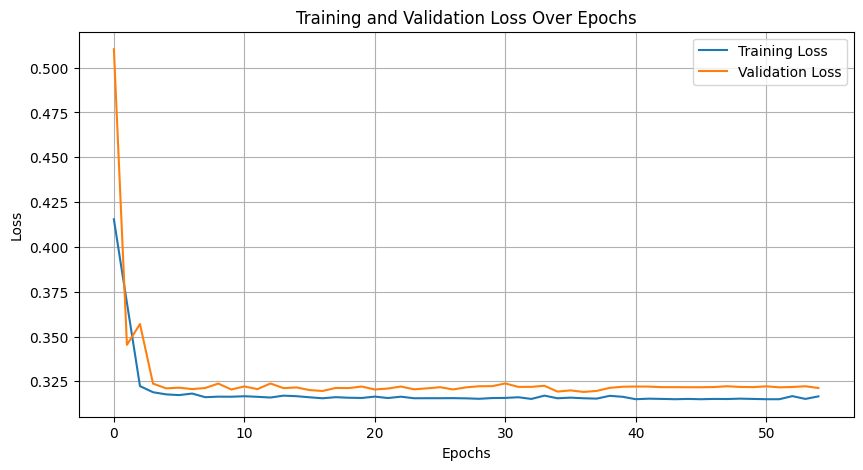

In [ ]:
# Load the dataset
X_train, y_train, X_test, y_test, X_val, y_val = train_M, train_Y, test_M, test_Y, val_M, val_Y

# Split the dataset into training, validation and test sets
train_dataset = SPDataset(X_train, y_train)
val_dataset = SPDataset(X_val, y_val)
test_dataset = SPDataset(X_test, y_test)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model -> doubling the dimension of the input, all equal until the output layer.
input_size = X_train.shape[1]
hidden_size1 = 40 #number of neurons per layer
hidden_size2 = 40
hidden_size3 = 40
output_size = 2
dropout_p = 0.25 #lower to have less variability in the training dynamics.
model = SPMLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_p=dropout_p)
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() #generalization of the loss function
optimizer = optim.Adam(model.parameters()) #adam optimizer
#optimizer = optim.RMSprop(model.parameters())

# Train the model with early stopping
epochs = 100
patience = 20

best_model_state_dict, train_losses, val_losses = train_val_print(model, train_loader, val_loader, optimizer, criterion, epochs, patience)
model.load_state_dict(best_model_state_dict) #test using external test data

# Testing
test(model, test_loader, scorer=matthews_corrcoef)

plot_loss_curves(train_losses, val_losses)

### Optimization

Optimization of the number of neurons for each layer, of the dropout probability and of the learning rate.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    # Suggest values for the hyperparameters
    hidden_size1 = trial.suggest_int('hidden_size1', 32, 50)
    hidden_size2 = trial.suggest_int('hidden_size2', 32, 50)
    hidden_size3 = trial.suggest_int('hidden_size3', 32, 50)
    dropout_p = trial.suggest_float('dropout_p', 0.1, 0.5)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    # Create the model with these hyperparameters
    model = SPMLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_p=dropout_p)
    model.to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model with early stopping (e.g., using your `train_val` function)
    best_model_state_dict, train_losses, val_losses = train_val_print(model, train_loader, val_loader, optimizer, criterion, epochs, patience)

    # Load the best model for evaluation
    model.load_state_dict(best_model_state_dict)

    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_score = matthews_corrcoef(all_labels, all_preds) # Calculate MCC

    return val_score  # Return the validation score for optimization

# Create an Optuna study to maximize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  # You can adjust n_trials as needed

# Print the best hyperparameters and score
print("Best hyperparameters:", study.best_params)
print("Best validation score:", study.best_value)


[I 2024-10-31 11:24:35,955] A new study created in memory with name: no-name-c857af1d-c438-41ee-befc-55b10d1d7c4b


Validation score improved to 0.0000
Epoch [1/100], Loss: 0.7437, Val score: 0.0000
Epoch [2/100], Loss: 0.7437, Val score: 0.0000
Epoch [3/100], Loss: 0.7437, Val score: 0.0000
Epoch [4/100], Loss: 0.7437, Val score: 0.0000
Epoch [5/100], Loss: 0.7437, Val score: 0.0000
Epoch [6/100], Loss: 0.7437, Val score: 0.0000
Epoch [7/100], Loss: 0.7437, Val score: 0.0000
Epoch [8/100], Loss: 0.7437, Val score: 0.0000
Epoch [9/100], Loss: 0.7437, Val score: 0.0000
Epoch [10/100], Loss: 0.7437, Val score: 0.0000
Epoch [11/100], Loss: 0.7437, Val score: 0.0000
Epoch [12/100], Loss: 0.7437, Val score: 0.0000
Epoch [13/100], Loss: 0.7437, Val score: 0.0000
Epoch [14/100], Loss: 0.7437, Val score: 0.0000
Epoch [15/100], Loss: 0.7437, Val score: 0.0000
Epoch [16/100], Loss: 0.7437, Val score: 0.0000
Epoch [17/100], Loss: 0.7441, Val score: 0.0000
Validation score improved to 0.9638
Epoch [18/100], Loss: 0.7437, Val score: 0.9638
Epoch [19/100], Loss: 0.7437, Val score: 0.9328
Validation score improved

[I 2024-10-31 11:25:37,634] Trial 0 finished with value: 0.9656624919629787 and parameters: {'hidden_size1': 36, 'hidden_size2': 36, 'hidden_size3': 32, 'dropout_p': 0.21888440487370545, 'lr': 0.0006469620285490766}. Best is trial 0 with value: 0.9656624919629787.


Early stopping at epoch 45
Validation score improved to 0.0000
Epoch [1/100], Loss: 0.7439, Val score: 0.0000
Epoch [2/100], Loss: 0.7437, Val score: 0.0000
Epoch [3/100], Loss: 0.7437, Val score: 0.0000
Epoch [4/100], Loss: 0.7437, Val score: 0.0000
